In [1]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
print(y_train[0:5])

[5 0 4 1 9]


In [5]:
# convert using one hot encoding

print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [6]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

In [8]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


In [10]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

print(W)
print()
print(b)

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


In [11]:
def forward(x):
    return tf.matmul(x,W) + b

In [12]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [13]:
def activate(x):
    return tf.nn.softmax(forward(x))

In [14]:
def model(x):
    x = flatten(x)
    return activate(x)

In [15]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.1

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [18]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

In [19]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 500 loss: 176.88257
epoch  0 batch 1000 loss: 214.80328
end of epoch  0 loss 221839.72 accuracy 0.8149167
epoch  1 batch 500 loss: 206.1276
epoch  1 batch 1000 loss: 145.16835
end of epoch  1 loss 216982.12 accuracy 0.8226333
epoch  2 batch 500 loss: 169.53117
epoch  2 batch 1000 loss: 196.36026
end of epoch  2 loss 213829.17 accuracy 0.8272167
epoch  3 batch 500 loss: 172.28514
epoch  3 batch 1000 loss: 173.96254
end of epoch  3 loss 210430.03 accuracy 0.83066666
epoch  4 batch 500 loss: 161.20569
epoch  4 batch 1000 loss: 182.20525
end of epoch  4 loss 206470.05 accuracy 0.83503336
epoch  5 batch 500 loss: 190.57175
epoch  5 batch 1000 loss: 171.30872
end of epoch  5 loss 208921.97 accuracy 0.83255
epoch  6 batch 500 loss: 238.12854
epoch  6 batch 1000 loss: 199.50337
end of epoch  6 loss 206631.19 accuracy 0.8344167
epoch  7 batch 500 loss: 201.32297
epoch  7 batch 1000 loss: 186.5648
end of epoch  7 loss 203951.28 accuracy 0.83835
epoch  8 batch 500 loss: 186.96683
e

In [20]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84003335
test accuracy 0.8326


Text(0, 0.5, 'loss')

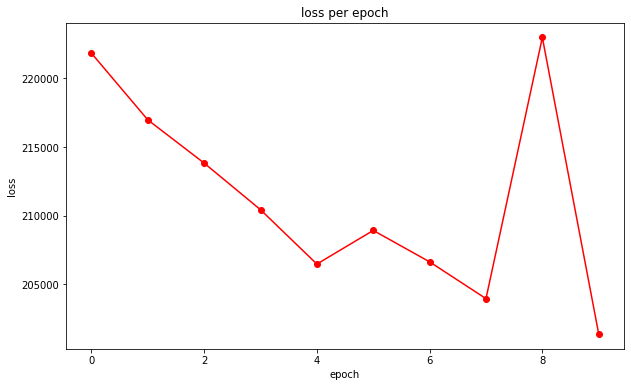

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

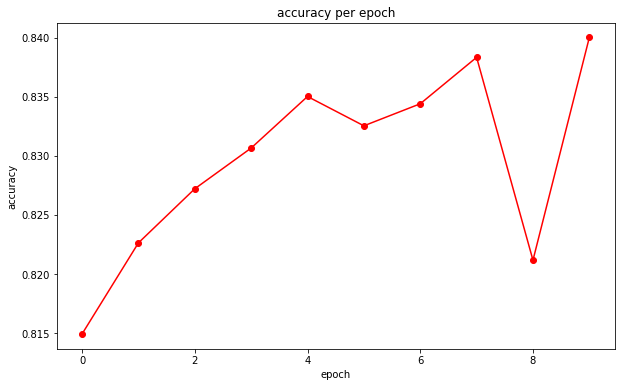

In [22]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")